In [1]:
%%capture
!pip install spacy --upgrade
!python -m spacy download en_core_web_sm

In [2]:
from warnings import filterwarnings
filterwarnings("ignore")

import spacy
import numpy as np
import pandas as pd
import re
import random
import zipfile
import seaborn as sns
import en_core_web_sm
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
zip_file = zipfile.ZipFile("/content/drive/MyDrive/NLP_Vol2/train.csv.zip","r")
zip_file.extractall()
zip_file.close()

In [4]:
train_data = pd.read_csv("/content/train.csv",header = None,
                         names = ["sentiment","id","date","query","user","text"],
                         encoding = "latin1")
train_data.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
print("Shape : " ,train_data.shape)

Shape :  (1600000, 6)


In [6]:
train_data["sentiment"].unique()

array([0, 4])

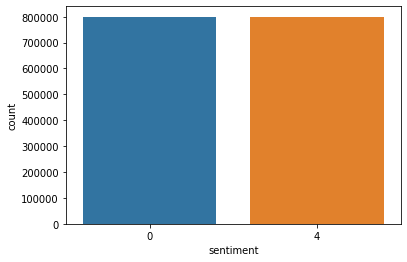

In [7]:
sns.countplot(train_data["sentiment"]);

In [8]:
train_data = train_data[["sentiment","text"]]
train_data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


# Train and Test Data

In [9]:
X = train_data.iloc[:,1].values
y = train_data.iloc[:,0].values
type(X),type(y)

(numpy.ndarray, numpy.ndarray)

In [10]:
X.shape,y.shape

((1600000,), (1600000,))

In [11]:
from sklearn.model_selection import train_test_split

X, _, y, _ =train_test_split(X,y, test_size = 0.97)
X.shape,y.shape

((48000,), (48000,))

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)
X_train.shape,X_test.shape

((38400,), (9600,))

In [13]:
np.unique(y_train, return_counts = True)

(array([0, 4]), array([19252, 19148]))

In [14]:
np.unique(y_test, return_counts = True)

(array([0, 4]), array([4799, 4801]))

# Preprocessing The Texts

In [15]:
nlp = spacy.load("en_core_web_sm")
nlp

In [37]:
def preprocessing(sentence):

    sentence = sentence.lower()
    sentence = re.sub(r"@[A-Za-z0-9]+", " " ,sentence)
    sentence = re.sub(r"https?://[A-Za-z0-9./]+" ," ", sentence)
    sentence = sentence.replace(".","")
    tokens = []
    tokens = [token.text for token in nlp(sentence) if not (token.is_stop or token.like_num or token.is_punct or token.is_space or len(token.text) == 1)]
    tokens = " ".join([element for element in tokens])
    return tokens

In [38]:
test = train_data["text"][0]
test

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [39]:
re.sub(r"@[A-Za-z0-9]+", " ",test)

"  http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [40]:
re.findall(r"https?://[A-Za-z0-9./]+" ,test)

['http://twitpic.com/2y1zl']

In [41]:
preprocessing(test)

'awww bummer shoulda got david carr day'

In [43]:
X_train_cleaned = [preprocessing(tweet) for tweet in X_train]

In [45]:
X_test_cleaned = [preprocessing(tweet) for tweet in X_test]

In [44]:
for _ in range(10):
    print(X_train_cleaned[random.randint(0, len(X_train_cleaned)- 1)])

love google cutesy random events holidays
getting breakfast paying night hope pay hat pic lol wtf
rain sucks
nt feel like pizza nt feel like lasagna pizza burnt nearly fell butt
king scotland great movie got finished watchin missin baby
starplayer tonight
bruins win celtics win sox win night boston sports
yeah everyones site cause rigrag server transfer
catching david mitchell podcasts
jazz museum cameras allowed inside


# WordCloud

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
texts = ""
for text in X_train_cleaned:
    texts +=" " + text

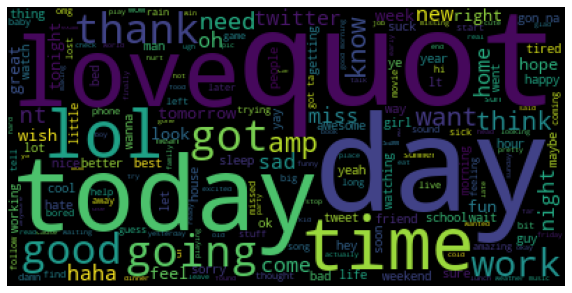

In [51]:
cloud = WordCloud()
cloud = cloud.generate(texts)

plt.figure(figsize = (10,10))
plt.imshow(cloud)
plt.axis("off")
plt.show()

# Detecting Language

In [55]:
%%capture
!pip install langdetect

from langdetect import detect

In [56]:
detect("This is an english text")

'en'

In [57]:
detect("Buraya nasıl geldik arkadaş?")

'tr'

In [ ]:
languages = []
for text in X_train_cleaned:
    if text != '':
        languages.append(detect(text))

In [60]:
np.unique(languages,return_counts = True)

(array(['af', 'ca', 'cs', 'cy', 'da', 'de', 'en', 'es', 'et', 'fi', 'fr',
        'hr', 'hu', 'id', 'it', 'lt', 'lv', 'nl', 'no', 'pl', 'pt', 'ro',
        'sk', 'sl', 'so', 'sq', 'sv', 'sw', 'tl', 'tr', 'vi'], dtype='<U2'),
 array([ 345,   44,    7,  103,   79,   19, 4359,   41,   97,   36,   96,
          13,    5,   62,   80,    5,    3,  110,  104,   38,   10,   48,
          12,   21,  188,   11,   43,   37,   99,   21,   14]))

# Sentiment Analysis With NLTK

In [66]:
import nltk
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [67]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [68]:
nltk_classifer = SentimentIntensityAnalyzer()
nltk_classifer.polarity_scores("I love this food")

{'compound': 0.6369, 'neg': 0.0, 'neu': 0.323, 'pos': 0.677}

In [69]:
nltk_classifer.polarity_scores("I have this food")

{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

In [70]:
X_train_cleaned[0]

'sounded like hehe glad btw great article going'

In [71]:
nltk_classifer

{'compound': 0.8625, 'neg': 0.0, 'neu': 0.342, 'pos': 0.658}

In [74]:
for i,sentence in enumerate(X_test):
    print(nltk_classifer.polarity_scores(sentence),  " - ", sentence)
    if i == 10:
        break

{'neg': 0.0, 'neu': 0.802, 'pos': 0.198, 'compound': 0.5719}  -  2 finals notes completed...2 more to go.  Alex is naht going to be a happy camper this week
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}  -  I don't think I did that right... 
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}  -  @Sammii_xxx Hey, I dont know if i told you but I posted that poster to you the other day 
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}  -  @danposluns I am trying and it's not working. I have a client coming in this week, too! 
{'neg': 0.09, 'neu': 0.91, 'pos': 0.0, 'compound': -0.1511}  -  I told you someday you come crawling back and asking me to take you in! &lt;3 Sorry Babe 
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}  -  hey twiggas.. i cant sleep...  
{'neg': 0.4, 'neu': 0.4, 'pos': 0.2, 'compound': -0.3591}  -  omg,my back aches like a bitch!this is not good! 
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}  -  @miss_tattoo don't think so...just got mo

# Sentiment Analysis With TF-IDK

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [76]:
X_train_cleaned[0:5]

['sounded like hehe glad btw great article going',
 'stupid hurts hell house keys',
 'got new chelsea kit 2day number sure',
 'feeling tiredthink sore throat coming',
 'yeah treat record ring']

In [77]:
y_train[:5]

array([4, 0, 4, 0, 4])

In [78]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train_cleaned)

In [79]:
# Çok fazla kelime var !!!
X_train_tfidf.shape

(38400, 33628)

In [80]:
def preprocessing_lemma(sentence):

    tokens = []
    tokens = [token.lemma_ for token in nlp(sentence)]
    tokens = " ".join([element for element in tokens])
    return tokens

In [81]:
preprocessing_lemma("learn learned learning")

'learn learn learn'

In [82]:
X_train_cleaned_lemma = [preprocessing_lemma(tweet) for tweet in X_train_cleaned]

In [83]:
# Önceki (38400, 33628)
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train_cleaned_lemma)
X_train_tfidf.shape

(38400, 30082)

In [84]:
X_test_cleaned_lemma = [preprocessing_lemma(tweet) for tweet in X_test_cleaned]

In [85]:
X_test_tfidf = vectorizer.transform(X_test_cleaned_lemma)
X_test_tfidf.shape

(9600, 30082)

In [91]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [89]:
X_train_tfidf.shape,X_test_tfidf.shape

((38400, 30082), (9600, 30082))

In [88]:
clf = DecisionTreeClassifier()
clf.fit(X_train_tfidf, y_train)

DecisionTreeClassifier()

In [90]:
predictions = clf.predict(X_test_tfidf)

In [92]:
metrics.confusion_matrix(y_test,predictions)

array([[3354, 1445],
       [1773, 3028]])

In [95]:
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.65      0.70      0.68      4799
           4       0.68      0.63      0.65      4801

    accuracy                           0.66      9600
   macro avg       0.67      0.66      0.66      9600
weighted avg       0.67      0.66      0.66      9600



In [97]:
print("Accuracy : ",metrics.accuracy_score(y_test,predictions).round(3))

Accuracy :  0.665


# Sentiment Analysis With Spacy

In [98]:
example = [["this is a positive text", {"POSITIVE": True, "NEGATIVE": False}],
           ["this is a negative text", {"POSITIVE": False, "NEGATIVE": True}]]

In [100]:
example[0]

['this is a positive text', {'NEGATIVE': False, 'POSITIVE': True}]

In [102]:
X_train_spacy = []
for text, sentiment in zip(X_train_cleaned_lemma, y_train):
    #print(text,sentiment)
    if sentiment  == 4:
        dic = ({"POSITIVE":True, "NEGATIVE" :False})
    elif sentiment == 0:
        dic = ({"POSITIVE":False, "NEGATIVE" :True})

    X_train_spacy.append([text,dic.copy()])

In [103]:
X_train_spacy[:3]

[['sound like hehe glad btw great article go',
  {'NEGATIVE': False, 'POSITIVE': True}],
 ['stupid hurt hell house key', {'NEGATIVE': True, 'POSITIVE': False}],
 ['get new chelsea kit 2day number sure',
  {'NEGATIVE': False, 'POSITIVE': True}]]

In [104]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [115]:
classifier_spacy = spacy.blank("en")
classifier_spacy.pipe_names

[]

In [116]:
# TextCategorizer -- > textcat
textcat = classifier_spacy.add_pipe("textcat")
classifier_spacy.pipe_names

['textcat']

In [117]:
textcat.add_label("POSITIVE")
textcat.add_label("NEGATIVE")

1

In [118]:
textcat.label_data

('POSITIVE', 'NEGATIVE')

In [110]:
from spacy.training import Example

In [112]:
len(X_train_spacy),len(X_train_spacy) / 1024

(38400, 37.5)

In [120]:
X_train_spacy[0]

['sound like hehe glad btw great article go',
 {'NEGATIVE': False, 'POSITIVE': True}]

In [191]:
# Entities -- > positive , negative
classifier_spacy.begin_training()
for epoch in range(10):
    random.shuffle(X_train_spacy)
    losses = {}
    for batch in spacy.util.minibatch(X_train_spacy, 1024):
        texts = [classifier_spacy.make_doc(text) for text,entities in batch]
        annotations = [{"cats":entities} for text,entities in batch]
        examples = [Example.from_dict(doc, annotation) for doc, annotation in zip(texts,annotations)]
        classifier_spacy.update(examples, losses = losses)
    print(losses)

{'textcat': 1.6184222772608337e-05}
{'textcat': 1.2171131658078593e-05}
{'textcat': 9.252711919316425e-06}
{'textcat': 6.250890052683644e-06}
{'textcat': 3.792608055164237e-06}
{'textcat': 2.5464256943052987e-06}
{'textcat': 1.8032708695159272e-06}
{'textcat': 1.5091508878128934e-06}
{'textcat': 1.3259449698210801e-06}
{'textcat': 1.212441333109382e-06}


In [202]:
for i,j in enumerate(X_train_spacy):
    if j[0] == "think cavs crush magic come home north realize wrong":
        print(i)
        break

37888


In [203]:
X_train_spacy[i]

['think cavs crush magic come home north realize wrong',
 {'NEGATIVE': True, 'POSITIVE': False}]

In [204]:
for i in [examples[0],texts[0],annotations[0]]:
    print(i)
    print()

{'doc_annotation': {'cats': {'POSITIVE': False, 'NEGATIVE': True}, 'entities': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], 'links': {}}, 'token_annotation': {'ORTH': ['think', 'cavs', 'crush', 'magic', 'come', 'home', 'north', 'realize', 'wrong'], 'SPACY': [True, True, True, True, True, True, True, True, False], 'TAG': ['', '', '', '', '', '', '', '', ''], 'LEMMA': ['', '', '', '', '', '', '', '', ''], 'POS': ['', '', '', '', '', '', '', '', ''], 'MORPH': ['', '', '', '', '', '', '', '', ''], 'HEAD': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'DEP': ['', '', '', '', '', '', '', '', ''], 'SENT_START': [1, 0, 0, 0, 0, 0, 0, 0, 0]}}

think cavs crush magic come home north realize wrong

{'cats': {'POSITIVE': False, 'NEGATIVE': True}}



In [123]:
classifier_spacy.to_disk("classifier_spacy")

In [141]:
classifier_spacy_loaded = spacy.load("classifier_spacy")
classifier_spacy_loaded

In [168]:
positive_text = "sun shine happy"
positive_text

'sun shine happy'

In [169]:
predictions = classifier_spacy_loaded(positive_text)
predictions

sun shine happy

In [170]:
predictions.cats

{'NEGATIVE': 0.00022835269919596612, 'POSITIVE': 0.9997716546058655}

In [171]:
classifier_spacy_loaded("i love this food").cats

{'NEGATIVE': 2.782702176773455e-05, 'POSITIVE': 0.9999722242355347}

In [174]:
y_test[1]
negative_text = X_test_cleaned_lemma[2]
classifier_spacy_loaded(negative_text).cats

{'NEGATIVE': 0.6586171984672546, 'POSITIVE': 0.34138286113739014}

In [181]:
np.array(X_test_cleaned_lemma).shape,np.array(y_test).shape

((9600,), (9600,))

In [183]:
predictions = []
for text in X_test_cleaned_lemma:
    prediction = classifier_spacy_loaded(text)
    predictions.append(prediction.cats)

In [184]:
predictions2 = []
for prediction in predictions:
    if prediction["POSITIVE"] > prediction["NEGATIVE"]:
        predictions2.append(4)
    else:
        predictions2.append(0)

predictions2 = np.array(predictions2)

In [185]:
metrics.confusion_matrix(y_test,predictions2)

array([[3388, 1411],
       [1533, 3268]])

In [188]:
print(metrics.classification_report(y_test,predictions2))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70      4799
           4       0.70      0.68      0.69      4801

    accuracy                           0.69      9600
   macro avg       0.69      0.69      0.69      9600
weighted avg       0.69      0.69      0.69      9600



In [190]:
# DecisionTreeClassifier -- > Accuracy :  0.665

print("Accuracy : ",metrics.accuracy_score(y_test,predictions2).round(3))

Accuracy :  0.693
